More into: https://www.overleaf.com/read/kpmkqqmjqdtr and https://www.overleaf.com/read/rwfgqzvwkqkc

# Imports:
You'll need to have run 'python -m pip install .' from the folder containing setup.py first

In [18]:
import os,sys
from chemical_potentials import nitrogen_chemical_potential as ncp
from chemical_potentials import general_functions as gf
import numpy as np
import matplotlib.pyplot as plt

I have a preset offset for PBE (0.75eV/N2) and SCAN () based on calculations for TiN, AlN, CrN, VN, and ZrN with my calculation settings.

In [19]:
ncp.print_constants()
#ncp.nitrogen_mu_0(300,offset=0)

kb =  1.380668660666e-23  J/K
 B_0 =  3.97212135e-23  J
 omega_0 =  70726500000000.0  J
 h =  6.6261667280564e-34  J*s
 p_0 = 101325.0 Pa
 m =  4.6517342e-26  kg
 sigma_sym =  2 
  I_spin =  1 



# Input your N, and MN VASP energies from as individual entries

In [20]:
additional_offset = 0.4020269921976742 #0.20376568512889898 #eV/N This value you'll need to determine based on the fitting. I used ~0.20 eV/N for PBE at my calculation settings.
# Vasp energies (eV)
### PBE ###
# N2 binding energy PBE
N2_molecule_vasp = -16.64101840/2 #PBE N2 molecule (per atom). This gets factored into the formation enthalpy checks # TODO: Check the relaxation for this, bond distance looks incorrect.
offset = additional_offset + N2_molecule_vasp
N2_separated_vasp = -6.24872394/2 #PBE N2 separated (per atom)
binding_energy_N2_vasp = N2_molecule_vasp - N2_separated_vasp #PBE binding energy of N2 (per atom)
print("PBE binding energy of N2: ", binding_energy_N2_vasp, "eV/atom")

TiN_fcc_vasp = -19.63752789/2 #PBE TiN fcc (per atom)
Ti_vasp = -23.52120854/3 #PBE Ti hcp (per atom)
AlN_wurtzite_vasp = -29.78281926/4 #PBE AlN wurtzite (per atom)
Al_vasp = -14.98180931/4 #PBE Al fcc (per atom)
CrN_hex_vasp = -18.91592839/2 #PBE CrN hexagonal (per atom)
Cr_vasp = -19.02043759/2 #PBE Cr bcc (per atom)
VN_hex_vasp = -19.68372627/2 #PBE VN hexagonal (per atom)
V_vasp = -17.98143454/2 #PBE V bcc (per atom)
ZrN_fcc_vasp = -20.37142413/2 #PBE ZrN fcc (per atom)
Zr_vasp = -17.04196849/2 #PBE Zr bcc (per atom)

PBE binding energy of N2:  -5.19614723 eV/atom


In [21]:
# Load JANAF data
janaf_data_path = '../JANAF_data/Nitrides/'
_N2_janaf = gf.calculate_mu_from_janaf(os.path.join(janaf_data_path,"N2-ref-023.txt"),T_min=0,T_max=2500)
N_janaf = (_N2_janaf[0]/2,_N2_janaf[1])

Loading ../JANAF_data/Nitrides/N2-ref-023.txt


# match T values between JANAF data
TiN_janaf, Ti_ref_janaf = gf.match_mu_T_data(TiN_janaf, Ti_ref_janaf)
VN_janaf, AlN_janaf = gf.match_mu_T_data(VN_janaf, AlN_janaf)
CrN_janaf, AlN_janaf = gf.match_mu_T_data(CrN_janaf, AlN_janaf)
N_janaf, Ti_ref_janaf = gf.match_mu_T_data(N_janaf, Ti_ref_janaf)
N_janaf, AlN_janaf = gf.match_mu_T_data(N_janaf, AlN_janaf)

# Calculate mu_N vs T

In [22]:
# Define temperature range
T = N_janaf[1] # Temperature in K
print("Temperature range: ", T[0], T[-1], "Shape: ", T.shape)
# Calculate nitrogen chemical potential
mu_N = np.zeros(len(T))
mu_N_for_janaf_check = np.zeros(len(T))
delta_mu_N2_vib = np.zeros(len(T))
for i in range(len(T)):
    mu_N_for_janaf_check[i] = ncp.nitrogen_mu_0(T[i],offset=additional_offset)
    mu_N[i] = ncp.nitrogen_mu_0(T[i],offset=offset)
    delta_mu_N2_vib[i] = ncp._delta_mu_nitrogen_vibrational_component(T[i])
# join mu_N and T
mu_N_T = np.row_stack((mu_N,T))


Temperature range:  0.0 2500.0 Shape:  (30,)


In [23]:
N_janaf[0]

array([-0.04492911, -0.11270677, -0.20134666, -0.24885777, -0.29604615,
       -0.2978831 , -0.3481739 , -0.39954984, -0.45187101, -0.50504308,
       -0.61362487, -0.72482104, -0.8383015 , -0.95381491, -1.07118353,
       -1.19025499, -1.31088421, -1.43297893, -1.55643241, -1.68116224,
       -1.80709745, -1.9341722 , -2.06233002, -2.19150716, -2.32165337,
       -2.4527422 , -2.58472651, -2.71755603, -2.85121883, -2.98565584])

mu_N:  [ 0.40202699  0.33436979  0.2458065   0.19833855  0.15118849  0.14935219
  0.09910261  0.0477703  -0.00451111 -0.05763935 -0.16613097 -0.27722845
 -0.39060237 -0.50600905 -0.62325847 -0.74219641 -0.862694   -0.98464128
 -1.10794292 -1.23251529 -1.35828435 -1.48518403 -1.61315498 -1.74214363
 -1.87210133 -2.00298378 -2.13475041 -2.26736398 -2.40079018 -2.53499732]


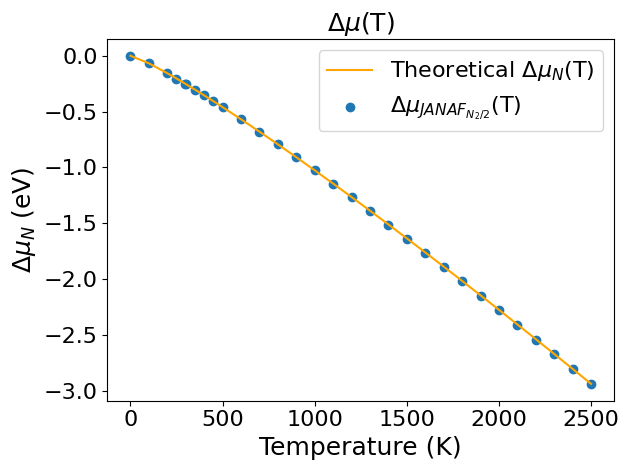

In [24]:
# Plot JANAF nitrogen chemical potential
fig, ax1 = plt.subplots()
ax1.plot(T,mu_N_for_janaf_check-mu_N_for_janaf_check[0],color='orange',label=r'Theoretical $\Delta$$\mu_N$(T)')
ax1.scatter(N_janaf[1],N_janaf[0]-N_janaf[0][0],label="$\Delta\mu_{JANAF_{N_2/2}}$(T)")
#ax1.scatter(TiN_janaf[1],TiN_janaf[0],label="JANAF-TiN")
janaf_offset=mu_N_for_janaf_check-N_janaf[0]
#print("offset: ", janaf_offset)
#print("offset amount: ", N_janaf[0])
print("mu_N: ", mu_N_for_janaf_check)
#plot difference
#ax1.plot(T,mu_N_for_janaf_check-janaf_offset[0],label=r'$\Delta$$\mu_N$ - $\Delta$$\mu_N$ offset @0K')
#plot vibrational component of delta_mu_O
#ax1.plot(T,delta_mu_N2_vib,label=r'$\Delta$$\mu_N$ vibrational component')
#show offset amount
#ax1.hlines(y=janaf_offset[0],xmin=T[0],xmax=T[-1],label=r'$\Delta$$\mu_N$ offset @0K',linestyles='dashed')
ax1.legend(fontsize=16)
ax1.set_xlabel(r'Temperature (K)',fontsize=18)
ax1.set_ylabel(r'$\Delta\mu_N$ (eV)',fontsize=18)
ax1.set_title(r'$\Delta\mu$(T)',fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=16)
fig.tight_layout()
fig.savefig('/home/jonnyli/Pictures/N_chemical_potential_delta_plot.png',dpi=300)

calculate dH = dH_vasp - dH_janaf


calculate dH_vasp = H(TiN)_vasp - H(Ti)_vasp - 0.5*mu(N2)_vasp 

where mu(N2)_vasp = E(N2)_vasp + delta_mu_N2 (the output from the nitrogen_mu_0(T,p,offset) with offset = E(N2)_vasp + offset_based_on_calculation_parameters))

In [25]:
######## START Loading JANAF formation enthalpies ########
# TiN (fcc)
dH_from_janaf_TiN_fcc = gf.formation_enthalpy_from_janaf(os.path.join(janaf_data_path,"TiN-cr-014.txt"),T_min=0,T_max=1000)
#'''
print('--------------------------\n',dH_from_janaf_TiN_fcc[0],type(dH_from_janaf_TiN_fcc[0]))
# normalize to per N2 molecule
print("normalizing TiN_fcc to per N2 molecule")
for k,j in enumerate(dH_from_janaf_TiN_fcc[0]):
    dH_from_janaf_TiN_fcc[0][k] = j*2
print('--------------------------\n',dH_from_janaf_TiN_fcc[0],type(dH_from_janaf_TiN_fcc[0]))
#'''

# AlN Wurtzite
dH_from_janaf_AlN_wurtzite = gf.formation_enthalpy_from_janaf(os.path.join(janaf_data_path,"AlN-cr-071.txt"),T_min=0,T_max=1000)
#'''
print('--------------------------\n',dH_from_janaf_AlN_wurtzite[0],type(dH_from_janaf_AlN_wurtzite[0]))
# normalize to per N2 molecule
print("normalizing AlN_wurtzite to per N2 molecule")
for k,j in enumerate(dH_from_janaf_AlN_wurtzite[0]):
    dH_from_janaf_AlN_wurtzite[0][k] = j*2
print('--------------------------\n',dH_from_janaf_AlN_wurtzite[0],type(dH_from_janaf_AlN_wurtzite[0]))
#'''

# CrN (hexagonal)
dH_from_janaf_CrN_hex = gf.formation_enthalpy_from_janaf(os.path.join(janaf_data_path,"CrN-cr-008.txt"),T_min=0,T_max=1000)
#'''
print('--------------------------\n',dH_from_janaf_CrN_hex[0],type(dH_from_janaf_CrN_hex[0]))
# normalize to per N2 molecule
print("normalizing CrN_hex to per N2 molecule")
for k,j in enumerate(dH_from_janaf_CrN_hex[0]):
    dH_from_janaf_CrN_hex[0][k] = j*2
print('--------------------------\n',dH_from_janaf_CrN_hex[0],type(dH_from_janaf_CrN_hex[0]))
#'''

# VN (hexagonal)
dH_from_janaf_VN_hex = gf.formation_enthalpy_from_janaf(os.path.join(janaf_data_path,"VN-cr-017.txt"),T_min=0,T_max=1000)
#'''
print('--------------------------\n',dH_from_janaf_VN_hex[0],type(dH_from_janaf_VN_hex[0]))
# normalize to per N2 molecule
print("normalizing VN_hex to per N2 molecule")
for k,j in enumerate(dH_from_janaf_VN_hex[0]):
    dH_from_janaf_VN_hex[0][k] = j*2
print('--------------------------\n',dH_from_janaf_VN_hex[0],type(dH_from_janaf_VN_hex[0]))
#'''

# ZrN (fcc)
dH_from_janaf_ZrN_fcc = gf.formation_enthalpy_from_janaf(os.path.join(janaf_data_path,"ZrN-cr-019.txt"),T_min=0,T_max=1000)
#'''
print('--------------------------\n',dH_from_janaf_ZrN_fcc[0],type(dH_from_janaf_ZrN_fcc[0]))
# normalize to per N2 molecule
print("normalizing ZrN_fcc to per N2 molecule")
for k,j in enumerate(dH_from_janaf_ZrN_fcc[0]):
    dH_from_janaf_ZrN_fcc[0][k] = j*2
print('--------------------------\n',dH_from_janaf_ZrN_fcc[0],type(dH_from_janaf_ZrN_fcc[0]))
#'''
######## END Loading JANAF formation enthalpies ########

Loading ../JANAF_data/Nitrides/TiN-cr-014.txt
--------------------------
 [-3.46136545 -3.47884997 -3.49348432 -3.49948523 -3.49953705 -3.49940231
 -3.49575409 -3.49081034 -3.48544164 -3.47983457 -3.47443479 -3.46992633] <class 'numpy.ndarray'>
normalizing TiN_fcc to per N2 molecule
--------------------------
 [-6.92273089 -6.95769994 -6.98696863 -6.99897046 -6.9990741  -6.99880463
 -6.99150818 -6.98162067 -6.97088329 -6.95966915 -6.94886958 -6.93985266] <class 'numpy.ndarray'>
Loading ../JANAF_data/Nitrides/AlN-cr-071.txt
--------------------------
 [-3.24380906 -3.26221601 -3.28302746 -3.29567187 -3.2958377  -3.30199407
 -3.30421203 -3.30424312 -3.30337252 -3.30255374 -3.30254338 -3.41360689] <class 'numpy.ndarray'>
normalizing AlN_wurtzite to per N2 molecule
--------------------------
 [-6.48761813 -6.52443201 -6.56605492 -6.59134374 -6.5916754  -6.60398815
 -6.60842405 -6.60848624 -6.60674504 -6.60510749 -6.60508676 -6.82721378] <class 'numpy.ndarray'>
Loading ../JANAF_data/Nitride

In [26]:
# Length checks
print("N: ", mu_N, len(mu_N), "\ndHf TiN: ", dH_from_janaf_TiN_fcc[0], len(dH_from_janaf_TiN_fcc[0]), "\ndHf AlN: ", dH_from_janaf_AlN_wurtzite[0], len(dH_from_janaf_AlN_wurtzite[0]), "\ndHf CrN: ", dH_from_janaf_CrN_hex[0], len(dH_from_janaf_CrN_hex[0]), "\ndHf VN: ", dH_from_janaf_VN_hex[0], len(dH_from_janaf_VN_hex[0]), "\ndHf ZrN: ", dH_from_janaf_ZrN_fcc[0], len(dH_from_janaf_ZrN_fcc[0]))

# match lengths
mu_N_T, dH_from_janaf_AlN_wurtzite = gf.match_mu_T_data(mu_N_T, dH_from_janaf_AlN_wurtzite)
mu_N_T, dH_from_janaf_CrN_hex = gf.match_mu_T_data(mu_N_T, dH_from_janaf_CrN_hex)
mu_N_T, dH_from_janaf_VN_hex = gf.match_mu_T_data(mu_N_T, dH_from_janaf_VN_hex)
mu_N_T, dH_from_janaf_ZrN_fcc = gf.match_mu_T_data(mu_N_T, dH_from_janaf_ZrN_fcc)

# recast to mu_N
mu_N = mu_N_T[0]
T = mu_N_T[1]



N:  [ -7.91848221  -7.98613941  -8.0747027   -8.12217065  -8.16932071
  -8.17115701  -8.22140659  -8.2727389   -8.32502031  -8.37814855
  -8.48664017  -8.59773765  -8.71111157  -8.82651825  -8.94376767
  -9.06270561  -9.1832032   -9.30515048  -9.42845212  -9.55302449
  -9.67879355  -9.80569323  -9.93366418 -10.06265283 -10.19261053
 -10.32349298 -10.45525961 -10.58787318 -10.72129938 -10.85550652] 30 
dHf TiN:  [-6.92273089 -6.95769994 -6.98696863 -6.99897046 -6.9990741  -6.99880463
 -6.99150818 -6.98162067 -6.97088329 -6.95966915 -6.94886958 -6.93985266] 12 
dHf AlN:  [-6.48761813 -6.52443201 -6.56605492 -6.59134374 -6.5916754  -6.60398815
 -6.60842405 -6.60848624 -6.60674504 -6.60510749 -6.60508676 -6.82721378] 12 
dHf CrN:  [-2.41414929 -2.44478607 -2.46750455 -2.4283898  -2.42785086 -2.41176551
 -2.39362804 -2.37710739 -2.36176827 -2.3475485  -2.33465535 -2.32354485] 12 
dHf VN:  [-4.44426094 -4.47265904 -4.49318029 -4.50120224 -4.5012437  -4.4997927
 -4.49251698 -4.48194543 -4.469

In [27]:
######## START Calculating dH = vasp - JANAF ########

# TiN (fcc) normalized to per N2 molecule
dH_vasp_TiN_fcc = (TiN_fcc_vasp*2 - Ti_vasp - mu_N)*2 # per N2 molecule
dH_TiN_fcc = dH_vasp_TiN_fcc - dH_from_janaf_TiN_fcc[0]

# AlN (wurtzite) normalized to per N2 molecule
dH_vasp_AlN_wurtzite = (AlN_wurtzite_vasp*2 - Al_vasp - mu_N)*2 #per N2 molecule
dH_AlN_wurtzite = dH_vasp_AlN_wurtzite - dH_from_janaf_AlN_wurtzite[0]

# CrN (hexagonal) normalized to per N2 molecule
dH_vasp_CrN_hex = (CrN_hex_vasp*2 - Cr_vasp - mu_N)*2 #per N2 molecule
dH_CrN_hex = dH_vasp_CrN_hex - dH_from_janaf_CrN_hex[0]

# VN (hexagonal) normalized to per N2 molecule
dH_vasp_VN_hex = (VN_hex_vasp*2 - V_vasp - mu_N)*2 #per N2 molecule
dH_VN_hex = dH_vasp_VN_hex - dH_from_janaf_VN_hex[0]

# ZrN (fcc) normalized to per N2 molecule
dH_vasp_ZrN_fcc = (ZrN_fcc_vasp*2 - Zr_vasp - mu_N)*2 #per N2 molecule
dH_ZrN_fcc = dH_vasp_ZrN_fcc - dH_from_janaf_ZrN_fcc[0]

######## END Calculating dH = vasp - JANAF ########

# Plot differences in formation enthalpy (VASP vs JANAF)

Nitrogen offset is:  0.4471963186528901  eV at 298.15 K
dH_TiN is:  -0.25663821208917525  eV at  298.15  K
dH_AlN is:  0.6380705505624382  eV at  298.15  K
dH_CrN is:  -0.04438797459680055  eV at  298.15  K
dH_VN is:  -0.5461743438102564  eV at  298.15  K
dH_ZrN is:  0.20912997993379356  eV at  298.15  K


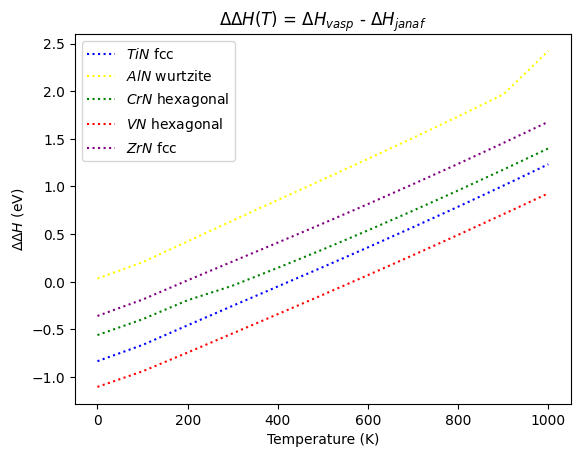

In [28]:
i = 3 # you can use this to change the T value you want to look at
fig2, ax2 = plt.subplots()
ax2.plot(T,dH_TiN_fcc,label=r'$TiN$ fcc',linestyle='dotted',color='blue')
ax2.plot(T,dH_AlN_wurtzite,label=r'$AlN$ wurtzite',linestyle='dotted',color='yellow')
ax2.plot(T,dH_CrN_hex,label=r'$CrN$ hexagonal',linestyle='dotted',color='green')
ax2.plot(T,dH_VN_hex,label=r'$VN$ hexagonal',linestyle='dotted',color='red')
ax2.plot(T,dH_ZrN_fcc,label=r'$ZrN$ fcc',linestyle='dotted',color='purple')
print("Nitrogen offset is: ",janaf_offset[i]," eV at", T[i], "K")
print("dH_TiN is: ",dH_TiN_fcc[i]," eV at ", T[i]," K")
print("dH_AlN is: ",dH_AlN_wurtzite[i]," eV at ", T[i]," K")
print("dH_CrN is: ",dH_CrN_hex[i]," eV at ", T[i]," K")
print("dH_VN is: ",dH_VN_hex[i]," eV at ", T[i]," K")
print("dH_ZrN is: ",dH_ZrN_fcc[i]," eV at ", T[i]," K")


ax2.set_title(r'$\Delta\Delta H(T)$ = $\Delta H_{vasp}$ - $\Delta H_{janaf}$')
plt.xlabel('Temperature (K)')
ax2.set_ylabel(r'$\Delta\Delta H$ (eV)')
ax2.legend()

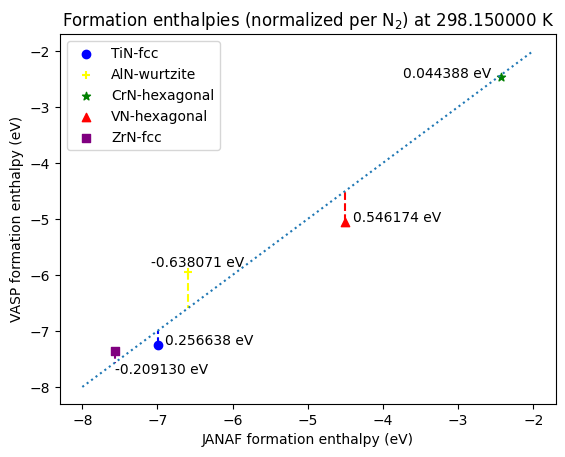

In [53]:
fig3, ax4 = plt.subplots()
# plot JANAF enthalpies vs VASP enthalpies
ax4.scatter(dH_from_janaf_TiN_fcc[0][i],dH_vasp_TiN_fcc[i],label="TiN-fcc",color='blue')
ax4.scatter(dH_from_janaf_AlN_wurtzite[0][i],dH_vasp_AlN_wurtzite[i],label="AlN-wurtzite",marker='+',color='yellow')
ax4.scatter(dH_from_janaf_CrN_hex[0][i],dH_vasp_CrN_hex[i],label="CrN-hexagonal",marker='*',color='green')
ax4.scatter(dH_from_janaf_VN_hex[0][i],dH_vasp_VN_hex[i],label="VN-hexagonal",marker='^',color='red')
ax4.scatter(dH_from_janaf_ZrN_fcc[0][i],dH_vasp_ZrN_fcc[i],label="ZrN-fcc",marker='s',color='purple')

# plot vertical deviation from y=x line
ax4.plot([dH_from_janaf_TiN_fcc[0][i],dH_from_janaf_TiN_fcc[0][i]],[dH_vasp_TiN_fcc[i],dH_from_janaf_TiN_fcc[0][i]],linestyle='dashed',color='blue')
TiN_diff = dH_from_janaf_TiN_fcc[0][i]-dH_vasp_TiN_fcc[i]
ax4.annotate('%f eV' % (TiN_diff), xy=(dH_from_janaf_TiN_fcc[0][i],dH_vasp_TiN_fcc[i]), xytext=(dH_from_janaf_TiN_fcc[0][i]+0.1,dH_vasp_TiN_fcc[i]))
ax4.plot([dH_from_janaf_AlN_wurtzite[0][i],dH_from_janaf_AlN_wurtzite[0][i]],[dH_vasp_AlN_wurtzite[i],dH_from_janaf_AlN_wurtzite[0][i]],linestyle='dashed',color='yellow')
AlN_diff = dH_from_janaf_AlN_wurtzite[0][i]-dH_vasp_AlN_wurtzite[i]
ax4.annotate('%f eV' % (AlN_diff), xy=(dH_from_janaf_AlN_wurtzite[0][i],dH_vasp_AlN_wurtzite[i]), xytext=(dH_from_janaf_AlN_wurtzite[0][i]-0.5,dH_vasp_AlN_wurtzite[i]+0.1))
ax4.plot([dH_from_janaf_CrN_hex[0][i],dH_from_janaf_CrN_hex[0][i]],[dH_vasp_CrN_hex[i],dH_from_janaf_CrN_hex[0][i]],linestyle='dashed',color='green')
CrN_diff = dH_from_janaf_CrN_hex[0][i]-dH_vasp_CrN_hex[i]
ax4.annotate('%f eV' % (CrN_diff), xy=(dH_from_janaf_CrN_hex[0][i],dH_vasp_CrN_hex[i]), xytext=(dH_from_janaf_CrN_hex[0][i]-1.3,dH_vasp_CrN_hex[i]))
ax4.plot([dH_from_janaf_VN_hex[0][i],dH_from_janaf_VN_hex[0][i]],[dH_vasp_VN_hex[i],dH_from_janaf_VN_hex[0][i]],linestyle='dashed',color='red')
VN_diff = dH_from_janaf_VN_hex[0][i]-dH_vasp_VN_hex[i]
ax4.annotate('%f eV' % (VN_diff), xy=(dH_from_janaf_VN_hex[0][i],dH_vasp_VN_hex[i]), xytext=(dH_from_janaf_VN_hex[0][i]+0.1,dH_vasp_VN_hex[i]))
ax4.plot([dH_from_janaf_ZrN_fcc[0][i],dH_from_janaf_ZrN_fcc[0][i]],[dH_vasp_ZrN_fcc[i],dH_from_janaf_ZrN_fcc[0][i]],linestyle='dashed',color='purple')
ZrN_diff = dH_from_janaf_ZrN_fcc[0][i]-dH_vasp_ZrN_fcc[i]
ax4.annotate('%f eV' % (ZrN_diff), xy=(dH_from_janaf_ZrN_fcc[0][i],dH_vasp_ZrN_fcc[i]), xytext=(dH_from_janaf_ZrN_fcc[0][i],dH_vasp_ZrN_fcc[i]-0.4))

    
#plot y=x line
axis_lim=[-8,-2]
ax4.plot(axis_lim,axis_lim,label='_nolegend_',linestyle='dotted')
#ax4.set_xlim(axis_lim[0],axis_lim[1])
#ax4.set_ylim(axis_lim[0],axis_lim[1])
plt.xlabel("JANAF formation enthalpy (eV)")
plt.ylabel("VASP formation enthalpy (eV)")
plt.title("Formation enthalpies (normalized per N$_2$) at %f K" % T[i])
ax4.legend()

In [54]:
print("Additional offset = ",additional_offset, "eV/N")
# get average of the differences
deviations = np.array([TiN_diff,AlN_diff,CrN_diff,VN_diff,ZrN_diff])
print("Average deviation = ",np.mean(deviations), "eV/N2")
print("Next try setting additional offset to ",additional_offset-np.mean(deviations)/2, "eV/N")

Additional offset =  0.4020269921976742 eV/N
Average deviation =  8.881784197001253e-17 eV/N2
Next try setting additional offset to  0.4020269921976741 eV/N


# Now that you have an offset, you can now get a value for your N chemical potential vs T as follows

[  20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.
  260.  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.
  500.  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.
  740.  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.
  980. 1000. 1020. 1040. 1060. 1080. 1100. 1120. 1140. 1160. 1180. 1200.
 1220. 1240. 1260. 1280. 1300. 1320. 1340. 1360. 1380. 1400. 1420. 1440.
 1460. 1480. 1500. 1520. 1540. 1560. 1580. 1600. 1620. 1640. 1660. 1680.
 1700. 1720. 1740. 1760. 1780. 1800. 1820. 1840. 1860. 1880. 1900. 1920.
 1940. 1960. 1980. 2000.]
(100,) (100,)


Text(0, 0.5, '$\\mu_N$ (eV)')

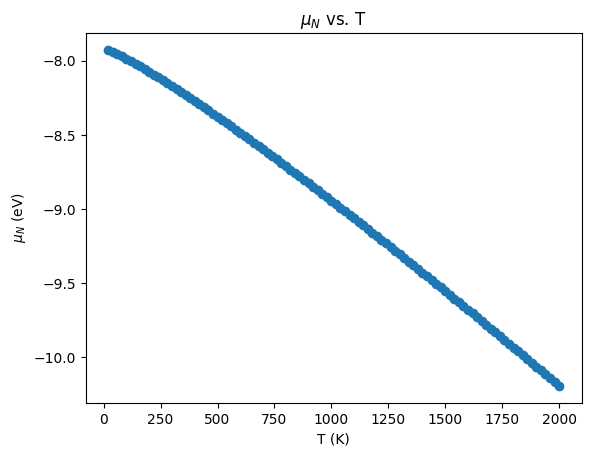

In [14]:
#Inputs
additional_offset = 0.4020269921976742 #eV/N This value you'll need to get from the previous step
N2_molecule_vasp = -16.64101840/2 #PBE N2 molecule (per atom) from you rcalculations

T_list = np.linspace(20,2000,100) #some array of temperatures
N_mu = np.zeros(T_list.shape) #initialize array of mu_N values
print(T_list)
for idx,i in enumerate(T_list):
    N_mu[idx] = ncp.nitrogen_mu_0(i,offset=N2_molecule_vasp+additional_offset) #get mu_N at each temperature
print(T_list.shape,N_mu.shape)

#plot mu_N vs T
fig, ax5 = plt.subplots()
ax5.scatter(T_list,N_mu)
ax5.set_title(r'$\mu_N$ vs. T')
plt.xlabel("T (K)")
plt.ylabel("$\mu_N$ (eV)")